In [29]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', 
        subset='training'
    )

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', 
        shuffle=False
    )

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ", image_batch.shape)
        break
       
    return noOfClasses, class_names, train_generator, validation_generator

def initiateModel(noOfClasses):
    base_model = EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights=None  # Changed from "imagenet" to None
    )
   
    # Since we're training from scratch, we'll make all layers trainable
    for layer in base_model.layers:
        layer.trainable = True
   
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=prediction)
    return model

# You may also want to adjust these parameters
gEpochs = 20  # Increased from 50 to 100 since we're training from scratch
lr = 0.001  # You might need to experiment with different learning rates
def modelSummary(model):
    model.summary()

# In the initiateParams function, you might want to adjust the learning rate schedule:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
    checkpoint = ModelCheckpoint(className + 'EfficientNetB0.h5', verbose=1, save_best_only=True)
   
    return model, annealer, checkpoint

def modelFit(model, annealer, checkpoint, train_generator, validation_generator, epochs=50, batchSize=32):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator)
    )
   
    return history

def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

def evalModel(model, validation_generator):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)

In [30]:
def saveModel(model, className):
    model.save(className + " - EfficientNetB0.h5")
    print("Model Saved!")

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    # Your existing plot_confusion_matrix function here
    # ...
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

def callPlot(model, validation_generator, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm=conf_mat,
                          normalize=False,
                          target_names=classes,
                          title=className + "Confusion Matrix")

# Main execution
mpath = r'/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20  # Increased from 20 to 50
lr = 0.001

for i in classPaths:
    print(i)

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 224, 224, 3)  7           rescaling_6[0][0]                
_____________

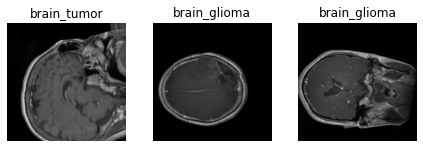

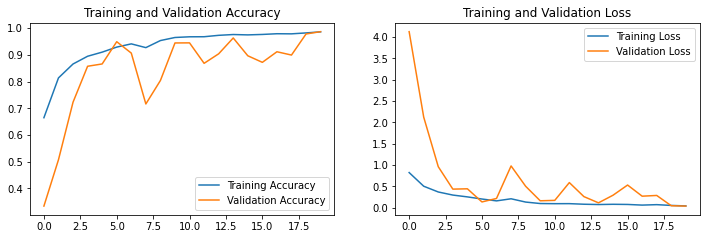

94/94 [==============================] - 40s 430ms/step - loss: 0.0432 - accuracy: 0.9867
Accuracy on the Test Set = 98.67 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

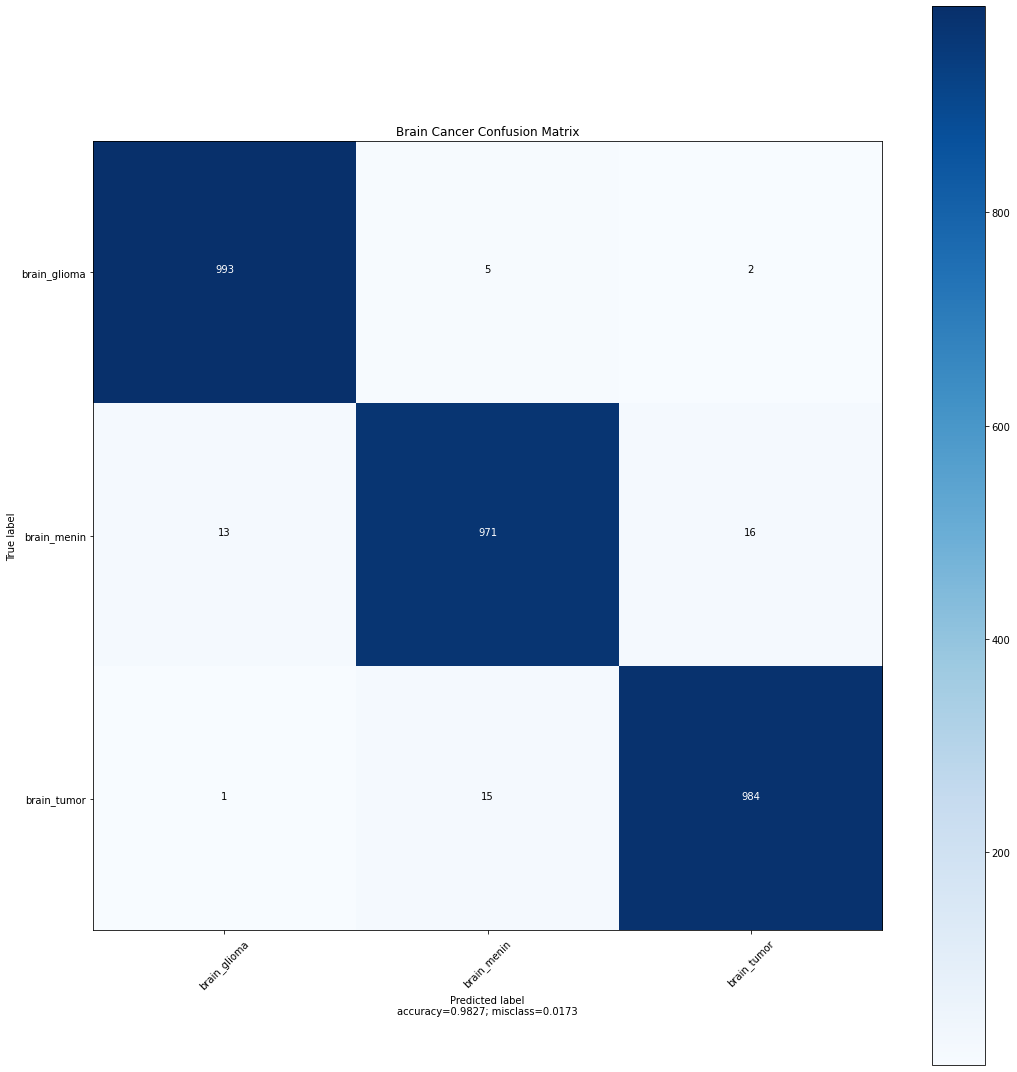

<Figure size 432x288 with 0 Axes>

In [31]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator, epochs=gEpochs, batchSize=32)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel, validation_generator)
saveModel(curModel, className)
callPlot(curModel, validation_generator, className, class_names)